# cs8321 Lab 1a - ConceptNet Ethics Testing

#### Chip Henderson - 48996654


In [7]:
# Import everything
import numpy as np
import pandas as pd
import matplotlib
# from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import Embedding, Input, Concatenate
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Subtract
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
import seaborn
import re
from sklearn.metrics import accuracy_score



### Intro

In this notebook I'm going to be comparing the results from our in-class discussion and modeling to my results when using a trained transformer. This code is set up to run in google colab so some parts need to be commented out when running on my local system.

In [8]:
# Uncomment for use in colab
# from google.colab import drive
# drive.mount('/content/drive/')

In [9]:
%%time
def load_embeddings(filename):
    """
    Load a DataFrame from the generalized text format used by word2vec, GloVe,
    fastText, and ConceptNet Numberbatch. The main point where they differ is
    whether there is an initial line with the dimensions of the matrix.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

# embeddings = load_embeddings('data/glove.840B.300d.txt') # course original
embeddings = load_embeddings('../Data_Sources/numberbatch-en.txt') # local PC
embeddings.shape

CPU times: total: 23.9 s
Wall time: 41.5 s


(516782, 300)

In [10]:
# Source: In class notebook 01 ConceptNet
def load_lexicon(filename):
    """
    Load a file from Bing Liu's sentiment lexicon
    (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), containing
    English words in Latin-1 encoding.

    One file contains a list of positive words, and the other contains
    a list of negative words. The files contain comment lines starting
    with ';' and blank lines, which should be skipped.
    """
    lexicon = []
    with open(filename, encoding='latin-1') as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

# For running on local system, use the following:
pos_words = load_lexicon('../Data_Sources/positive-words.txt')
neg_words = load_lexicon('../Data_Sources/negative-words.txt')

# For running in colab, use the following:
# pos_words = load_lexicon(r'/content/drive/MyDrive/Colab Notebooks/positive-words.txt') # colab version
# neg_words = load_lexicon(r'/content/drive/MyDrive/Colab Notebooks/negative-words.txt') # colab version

print(len(pos_words), len(neg_words))

2006 4783


In [11]:
NAMES_BY_ETHNICITY = {
    # The first two lists are from the Caliskan et al. appendix describing the
    # Word Embedding Association Test.
    'White': [
        'Adam', 'Chip', 'Harry', 'Josh', 'Roger', 'Alan', 'Frank', 'Ian', 'Justin',
        'Ryan', 'Andrew', 'Fred', 'Jack', 'Matthew', 'Stephen', 'Brad', 'Greg', 'Jed',
        'Paul', 'Todd', 'Brandon', 'Hank', 'Jonathan', 'Peter', 'Wilbur', 'Amanda',
        'Courtney', 'Heather', 'Melanie', 'Sara', 'Amber', 'Crystal', 'Katie',
        'Meredith', 'Shannon', 'Betsy', 'Donna', 'Kristin', 'Nancy', 'Stephanie',
        'Ellen', 'Lauren', 'Peggy', 'Colleen', 'Emily',
        'Megan', 'Rachel', 'Wendy'
    ],

    'Black': [
        'Alonzo', 'Jamel', 'Theo', 'Alphonse', 'Jerome',
        'Leroy', 'Torrance', 'Darnell', 'Lamar', 'Lionel',
        'Tyree', 'Deion', 'Lamont', 'Malik', 'Terrence', 'Tyrone',
        'Lavon', 'Marcellus', 'Wardell', #'Nichelle',
        'Ebony', 'Shaniqua',
        'Jasmine', 'Tanisha', 'Tia', 'Latoya',
        'Yolanda', 'Malika', 'Yvette'
    ],
    #Larson Edit: had to remove a number of names that were not in the embedding

    # This list comes from statistics about common Hispanic-origin names in the US.
    'Hispanic': [
        'Juan', 'José', 'Miguel', 'Jorge', 'Santiago',
        'Mateo',  'Alejandro', 'Samuel', 'Diego', 'Daniel',
        'Juana', 'Ana', 'Luisa', 'María', 'Elena', 'Isabella', 'Valentina',
        'Camila', 'Valeria', 'Ximena', 'Luciana', 'Mariana', 'Victoria', 'Martina'
    ],
    #Larson Edit: had to remove a number of names that were not in the embedding

    # The following list conflates religion and ethnicity, I'm aware. So do given names.
    #
    # This list was cobbled together from searching baby-name sites for common Muslim names,
    # as spelled in English. I did not ultimately distinguish whether the origin of the name
    # is Arabic or Urdu or another language.
    #
    # I'd be happy to replace it with something more authoritative, given a source.
    'Arab/Muslim': [
        'Mohammed', 'Omar', 'Ahmed', 'Ali', 'Youssef', 'Abdullah', 'Yasin', 'Hamza',
        'Syed', 'Samar', 'Ahmad', 'Rayyan', 'Mariam',
        'Jana', 'Malak', 'Salma', 'Nour', 'Lian', 'Fatima', 'Ayesha', 'Zahra', 'Sana',
        'Zara', 'Alya', 'Shaista', 'Zoya', 'Yasmin'
    ]
}

In [12]:
# # print(NAMES_BY_ETHNICITY.values())
# full_name_list = []
# for list in NAMES_BY_ETHNICITY.values():
#     for name in list:
#         full_name_list.append(name)

# print(len(full_name_list))

Note, vecs_to_sentiment is where the model prediction call is coming from in this code

In [13]:
def vecs_to_sentiment(vecs):
    # predict_log_proba gives the log probability for each class
    predictions = model.predict_log_proba(vecs)

    # To see an overall positive vs. negative classification in one number,
    # we take the log probability of positive sentiment minus the log
    # probability of negative sentiment.
    # this is a logarithm of the max margin for the classifier,
    # similar to odds ratio (but not exact) log(p_1/p_0) = log(p_1)-log(p_0)
    return predictions[:, 1] - predictions[:, 0]


def words_to_sentiment(words):
    vecs = embeddings.loc[words].dropna()
    log_odds = vecs_to_sentiment(vecs)
    return pd.DataFrame({'sentiment': log_odds}, index=vecs.index)


def name_sentiment_table():
    frames = []
    for group, name_list in sorted(NAMES_BY_ETHNICITY.items()):
        lower_names = [name.lower() for name in name_list]
        sentiments = words_to_sentiment(lower_names)
        sentiments['group'] = group
        frames.append(sentiments)

    # Put together the data we got from each ethnic group into one big table
    return pd.concat(frames)

In [14]:
import scipy.stats as stats

def retrain_model(new_embs, title = ''):
    """
    Repeat the steps above with a new set of word embeddings.
    """
    # use these from outside the function and update them globally
    global model, embeddings, name_sentiments
    embeddings = new_embs
    # get the positive and negative embeddings
    pos_words_common = list(set(pos_words) & set(embeddings.index))
    neg_words_common = list(set(neg_words) & set(embeddings.index))
    pos_vectors = embeddings.loc[pos_words_common]
    neg_vectors = embeddings.loc[neg_words_common]
    vectors = pd.concat([pos_vectors, neg_vectors])
    targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
    labels = list(pos_vectors.index) + list(neg_vectors.index)

    # split the data
    train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
        train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

    # train our model
    model = SGDClassifier(loss='log_loss', random_state=0, max_iter=100)
    model.fit(train_vectors, train_targets)

    # print out a goodness of fit
    accuracy = accuracy_score(model.predict(test_vectors), test_targets)
    print("Accuracy of sentiment: {:.2%}".format(accuracy))

    # get the name table of different people's names and save embeddings
    name_sentiments = name_sentiment_table()

    stats.f_oneway(
        name_sentiments['sentiment'][name_sentiments['group'] == 'White'],
        name_sentiments['sentiment'][name_sentiments['group'] == 'Black'],
        name_sentiments['sentiment'][name_sentiments['group'] == 'Hispanic'],
        name_sentiments['sentiment'][name_sentiments['group'] == 'Arab/Muslim'],
    )

    name_sentiments = name_sentiment_table()

    fstat,pval = stats.f_oneway(
        name_sentiments['sentiment'][name_sentiments['group'] == 'White'],
        name_sentiments['sentiment'][name_sentiments['group'] == 'Black'],
        name_sentiments['sentiment'][name_sentiments['group'] == 'Hispanic'],
        name_sentiments['sentiment'][name_sentiments['group'] == 'Arab/Muslim'],
    )
    print('F-statistic:',fstat,' With P-value:', pval)

    # Show the results on a swarm plot, with a consistent Y-axis
    matplotlib.pyplot.figure(figsize=(15,5))
    matplotlib.pyplot.subplot(121)
    plot = seaborn.swarmplot(x='group', y='sentiment', data=name_sentiments)
    plot.set_ylim([-10, 10])
    matplotlib.pyplot.subplot(122)
    plot = seaborn.barplot(x='group', y='sentiment', data=name_sentiments, capsize=.1)
    matplotlib.pyplot.suptitle(title, fontsize=16)

    print(fstat)

Accuracy of sentiment: 97.78%
F-statistic: 10.877995114514858  With P-value: 2.1757247157518317e-06
10.877995114514858


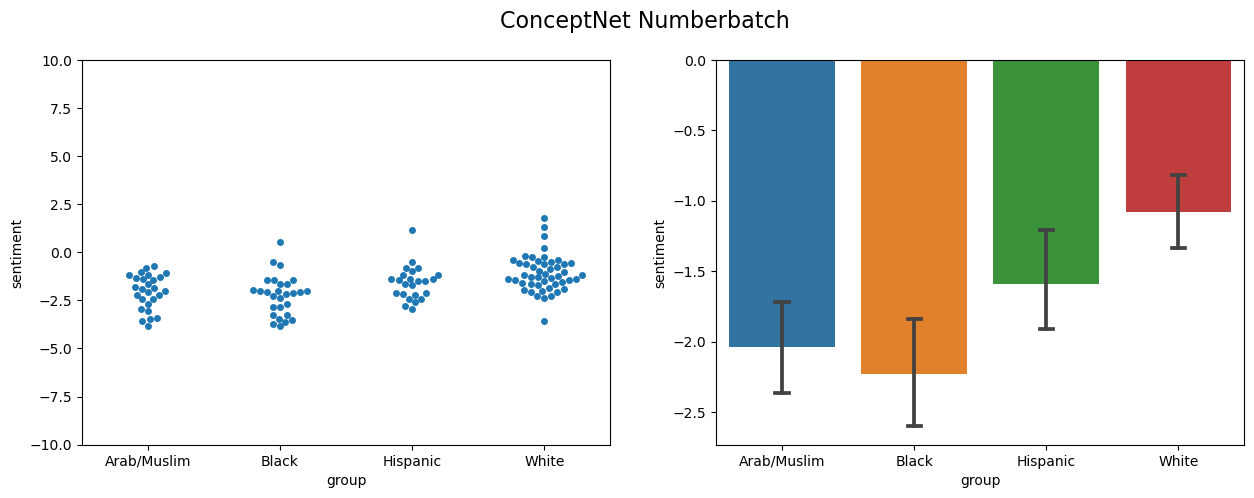

In [15]:
# Local PC version
retrain_model(load_embeddings('../Data_Sources/numberbatch-en.txt'), title='ConceptNet Numberbatch')
# Colab version
# retrain_model(load_embeddings('/content/drive/MyDrive/Colab Notebooks/numberbatch-en.txt'), title='ConceptNet Numberbatch')

Let's create some similar groupings for different ages.

In [40]:
# source:https://www.britannica.com/dictionary/eb/qa/Age-by-Decade#:~:text=A%20person%20between%2020%20and,59%20is%20called%20a%20quinquagenarian.
# source: https://www.ncbi.nlm.nih.gov/books/NBK556096/
# source: https://langeek.co/en/vocab/subcategory/900/word-list
'''
There are a lot of words that can be used to describe different stages of life.
I'm going to use the national library of medicine to define some of these groupings.
There are also a lot of words with multiple meanings and attemptint to not
unintentionally skew the data can be challenging. It's hard to stay away from 
adjectives which by definition describes or defines a noun and therefore impart
sentiment.
'''
AGE_BY_CATEGORY = {
    # The first two lists are from the Caliskan et al. appendix describing the
    # Word Embedding Association Test.
    'Young': [
        'infant','child','toddler','preschooler','girlhood',
        'youth','neonate','preteen','neonate','boyhood'
        ],
    'Teen': [
        'teenager','denarian','minor','juvenile','teen',
        'stripling','adolescent','fledgling','adolescence'
        ],
    'Adult': [
        'vicenarian','tricenarian','adult','quadragenarian',
        'manhood','womanhood',''
        ],
    'Old': [
        'retiree','elder','experienced','old','geriatric',
        'octogenarian','Nonagenarian','septuagenarian'
        ]
}

In [41]:
def vecs_to_sentiment(vecs):
    # predict_log_proba gives the log probability for each class
    predictions = model.predict_log_proba(vecs)

    # To see an overall positive vs. negative classification in one number,
    # we take the log probability of positive sentiment minus the log
    # probability of negative sentiment.
    # this is a logarithm of the max margin for the classifier,
    # similar to odds ratio (but not exact) log(p_1/p_0) = log(p_1)-log(p_0)
    return predictions[:, 1] - predictions[:, 0]


def words_to_sentiment(words):
    vecs = embeddings.loc[words].dropna()
    log_odds = vecs_to_sentiment(vecs)
    return pd.DataFrame({'sentiment': log_odds}, index=vecs.index)


def age_sentiment_table():
    frames = []
    for group, name_list in sorted(AGE_BY_CATEGORY.items()):
        lower_names = [name.lower() for name in name_list]
        sentiments = words_to_sentiment(lower_names)
        sentiments['group'] = group
        frames.append(sentiments)

    # Put together the data we got from each ethnic group into one big table
    return pd.concat(frames)

In [42]:
import scipy.stats as stats

def retrain_model_age(new_embs, title = ''):
    """
    Repeat the steps above with a new set of word embeddings.
    """
    # use these from outside the function and update them globally
    global model, embeddings, age_sentmient
    embeddings = new_embs
    # get the positive and negative embeddings
    pos_words_common = list(set(pos_words) & set(embeddings.index))
    neg_words_common = list(set(neg_words) & set(embeddings.index))
    pos_vectors = embeddings.loc[pos_words_common]
    neg_vectors = embeddings.loc[neg_words_common]
    vectors = pd.concat([pos_vectors, neg_vectors])
    targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
    labels = list(pos_vectors.index) + list(neg_vectors.index)

    # split the data
    train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
        train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

    # train our model
    model = SGDClassifier(loss='log_loss', random_state=0, max_iter=100)
    model.fit(train_vectors, train_targets)

    # print out a goodness of fit
    accuracy = accuracy_score(model.predict(test_vectors), test_targets)
    print("Accuracy of sentiment: {:.2%}".format(accuracy))

    # get the name table of different people's names and save embeddings
    age_sentiment = age_sentiment_table()

    stats.f_oneway(
        age_sentiment['sentiment'][age_sentiment['group'] == 'White'],
        age_sentiment['sentiment'][age_sentiment['group'] == 'Black'],
        age_sentiment['sentiment'][age_sentiment['group'] == 'Hispanic'],
        age_sentiment['sentiment'][age_sentiment['group'] == 'Arab/Muslim'],
    )

    age_sentiments = age_sentiment_table()

    fstat,pval = stats.f_oneway(
        age_sentiments['sentiment'][age_sentiments['group'] == 'White'],
        age_sentiments['sentiment'][age_sentiments['group'] == 'Black'],
        age_sentiments['sentiment'][age_sentiments['group'] == 'Hispanic'],
        age_sentiments['sentiment'][age_sentiments['group'] == 'Arab/Muslim'],
    )
    print('F-statistic:',fstat,' With P-value:', pval)

    # Show the results on a swarm plot, with a consistent Y-axis
    matplotlib.pyplot.figure(figsize=(15,5))
    matplotlib.pyplot.subplot(121)
    plot = seaborn.swarmplot(x='group', y='sentiment', data=age_sentiments)
    plot.set_ylim([-10, 10])
    matplotlib.pyplot.subplot(122)
    plot = seaborn.barplot(x='group', y='sentiment', data=age_sentiments, capsize=.1)
    matplotlib.pyplot.suptitle(title, fontsize=16)

    print(fstat)

Accuracy of sentiment: 97.78%
F-statistic: nan  With P-value: nan
nan


c:\Users\Chip\anaconda3\envs\mlenv7324\lib\site-packages\scipy\stats\_stats_py.py:4133: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '
c:\Users\Chip\anaconda3\envs\mlenv7324\lib\site-packages\scipy\stats\_stats_py.py:4133: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


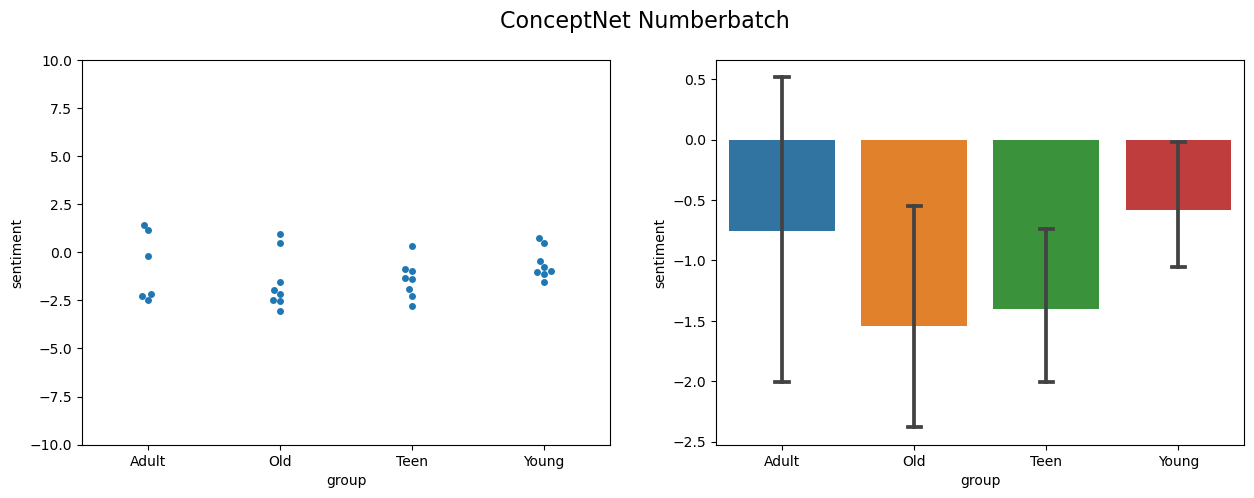

In [43]:
# Local PC version
retrain_model_age(load_embeddings('../Data_Sources/numberbatch-en.txt'), title='ConceptNet Numberbatch')
# Colab version
# retrain_model(load_embeddings('/content/drive/MyDrive/Colab Notebooks/numberbatch-en.txt'), title='ConceptNet Numberbatch')

In [44]:
print(AGE_BY_CATEGORY.items())

dict_items([('Young', ['infant', 'infancy', 'child', 'toddler', 'preschooler', 'youth', 'neonate', 'preteen']), ('Teen', ['teenager', 'denarian', 'minor', 'juvenile', 'teen', 'stripling', 'adolescent', 'fledgling']), ('Adult', ['vicenarian', 'tricenarian', 'adult', 'quadragenarian', 'manhood', 'womanhood']), ('Old', ['retiree', 'elder', 'experienced', 'old', 'geriatric', 'octogenarian', 'Nonagenarian', 'septuagenarian'])])
